
# Face Mask Detection – Komplettes Notebook-Gerüst 
# Ein CNN-Modell, mehrfach parametrisiert
# Datensatz: kagglehub "ashishjangra27/face-mask-12k-images-dataset"





In [1]:
# 0) Setup & Imports
import os, pathlib, math, random, shutil,json

import creds
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)

TensorFlow: 2.8.0


In [ ]:
# 1) Pfade definieren
NB_DIR = pathlib.Path.cwd()
PROJECT_ROOT = NB_DIR.parent
DATA_ROOT = PROJECT_ROOT / "data"

In [4]:
# 2) kaggle.json laden
kaggle_settings_path = NB_DIR / "kaggle.json"
if not kaggle_settings_path.exists():
    raise FileNotFoundError(f"kaggle.json nicht gefunden: {kaggle_settings_path}")

with open(kaggle_settings_path, "r") as f:
    creds = json.load(f)

os.environ["KAGGLE_USERNAME"] = creds["username"]
os.environ["KAGGLE_KEY"] = creds["key"]

# 3) Download nur, wenn Train-Ordner fehlt
if not (DATA_ROOT / "Train").exists():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    print("Starte Download des Face-Mask-Datasets mit KaggleHub …")

    # Liefert den entpackten Dataset-Ordner im lokalen Cache!
    dataset_root = pathlib.Path(
        kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
    )

    # In diesem Ordner liegt bereits „Face Mask Dataset/Train …“
    SRC = dataset_root / "Face Mask Dataset"

    import shutil

    for split in ["Train", "Validation", "Test"]:
        dst = DATA_ROOT / split
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(SRC / split, dst)

    print("Download abgeschlossen. Ordner Train/Validation/Test erstellt.")
else:
    print("Train/Validation/Test existieren bereits – Download übersprungen.")

print("Dataset liegt unter:", DATA_ROOT)


Starte Download des Face-Mask-Datasets mit KaggleHub …


100%|██████████| 330M/330M [00:31<00:00, 11.1MB/s] 

Extracting files...


Download abgeschlossen. Ordner Train/Validation/Test erstellt.
Dataset liegt unter: C:\Users\mu2me\PycharmProjects\Face-Mask-Detection-\data


In [5]:
# 2) Verzeichnisse setzen – Struktur: Train / Validation / Test
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
SEED       = 42

train_dir = DATA_ROOT / "Train"
val_dir   = DATA_ROOT / "Validation"
test_dir  = DATA_ROOT / "Test"


In [19]:
# 3) Daten laden
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print("Klassen:", class_names)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Klassen: ['WithMask', 'WithoutMask']


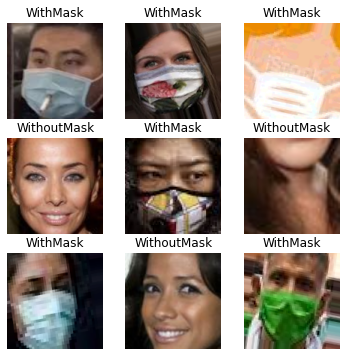

In [8]:
# 3.1) Beispielbilder anzeigen
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

In [10]:
# 5) Modell-Fabrik
def build_cnn(conv_blocks=2, dense_units=64, learning_rate=1e-3):
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for i in range(conv_blocks):
        x = layers.Conv2D(32 * (i + 1), 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    outputs = layers.Dense(len(class_names), activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [11]:
# 6) Hyperparameter-Varianten
VARIANTS = {
    "A_small":  {"conv_blocks": 2, "dense_units": 64,  "learning_rate": 1e-3, "epochs": 8}
    #"B_medium": {"conv_blocks": 3, "dense_units": 128, "learning_rate": 5e-4, "epochs": 12},
    #"C_large":  {"conv_blocks": 4, "dense_units": 128, "learning_rate": 1e-4, "epochs": 15},
}

histories, models = {}, {}

In [12]:
# 7) Training-Schleife
for name, p in VARIANTS.items():
    print(f"\n=== Trainiere Variante {name} ===")
    model = build_cnn(p["conv_blocks"], p["dense_units"], p["learning_rate"])
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=p["epochs"],
        verbose=2,
    )
    histories[name] = history
    models[name] = model



=== Trainiere Variante A_small ===
Epoch 1/8
313/313 - 143s - loss: 0.1908 - accuracy: 0.9286 - val_loss: 0.0452 - val_accuracy: 0.9837 - 143s/epoch - 458ms/step
Epoch 2/8
313/313 - 110s - loss: 0.0800 - accuracy: 0.9706 - val_loss: 0.0359 - val_accuracy: 0.9875 - 110s/epoch - 353ms/step
Epoch 3/8
313/313 - 157s - loss: 0.0668 - accuracy: 0.9774 - val_loss: 0.0211 - val_accuracy: 0.9900 - 157s/epoch - 500ms/step
Epoch 4/8
313/313 - 191s - loss: 0.0569 - accuracy: 0.9785 - val_loss: 0.0427 - val_accuracy: 0.9862 - 191s/epoch - 610ms/step
Epoch 5/8
313/313 - 127s - loss: 0.0538 - accuracy: 0.9817 - val_loss: 0.0216 - val_accuracy: 0.9925 - 127s/epoch - 407ms/step
Epoch 6/8
313/313 - 151s - loss: 0.0495 - accuracy: 0.9820 - val_loss: 0.0376 - val_accuracy: 0.9887 - 151s/epoch - 483ms/step
Epoch 7/8
313/313 - 113s - loss: 0.0550 - accuracy: 0.9801 - val_loss: 0.0339 - val_accuracy: 0.9862 - 113s/epoch - 361ms/step
Epoch 8/8
313/313 - 101s - loss: 0.0379 - accuracy: 0.9854 - val_loss: 0.02

In [13]:
# 8) Beste Variante ermitteln
best_name = max(histories, key=lambda n: max(histories[n].history["val_accuracy"]))
best_model = models[best_name]
print("\nBeste Variante:", best_name)


Beste Variante: A_small


In [14]:
# 9) Evaluation
def evaluate(model, dataset):
    y_true, y_pred = [], []
    for imgs, labels in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate(best_model, test_ds)

              precision    recall  f1-score   support

    WithMask       0.98      0.99      0.99       483
 WithoutMask       0.99      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992

Confusion Matrix:
[[478   5]
 [  9 500]]


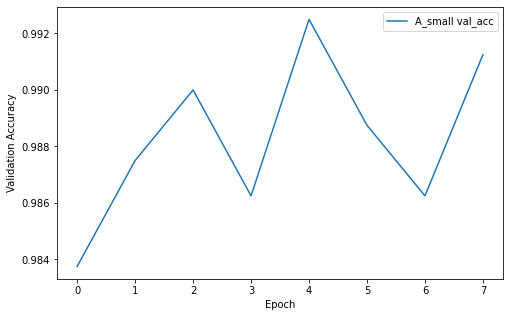

In [15]:
# 10) Trainingskurven Plot
plt.figure(figsize=(8, 5))

for name, hist in histories.items():         
    plt.plot(hist.history["val_accuracy"],    
             label=f"{name} val_acc")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()
